In [1]:
import numpy as np
import xarray as xr

import os
import time
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

In [2]:
def sporulation(T, c=2.0, Tmin=5.0, Topt=22.0, Tmax=26.0):
    
    parentesis_1 = (T - Tmin) / (Topt - Tmin)
    
    parentesis_2 = (Tmax - T) / (Tmax - Topt)
    
    exponent = (Tmax - Topt) / (Topt - Tmin)
    
    result = (parentesis_1*(parentesis_2)**exponent)**c
    
    result[(T<Tmin) | (T>Tmax)] = 0.0
    
    return result

def rainfall_spread(P, P_min=2.5):
    
    p = np.zeros(P.shape)
    
    p[P >= P_min] = 1.0

    m = np.sum(p, axis=0) / 7.0
      
    return m

def annual_suitability(year, min_lon, max_lon, min_lat, max_lat, P_min=2.5, c=2.0, Tmin=5.0, Topt=22.0, 
                       Tmax=26.0, data_path="/data/geo/ecmwf/Phytopthora/high_resolution/"):

    suitability_idx = 0.0

    for m in range(1, 13):
        
        print("Computing month %i" % m)

        filename_P = "%s/chelsa-w5e5v1.0_obsclim_pr_30arcsec_global_daily_%s%s.nc" % (data_path, year, str(m).zfill(2))
        filename_T = "%s/chelsa-w5e5v1.0_obsclim_tas_30arcsec_global_daily_%s%s.nc" % (data_path, year, str(m).zfill(2))

        ds_P = xr.open_dataset(filename_P)
        ds_T = xr.open_dataset(filename_T)

        for w in range(4):

            date_i = datetime(year, m, 1 + w*7)
            date_f = datetime(year, m, (w+1)*7)

            ds_P_i = ds_P.sel(time=slice(date_i, date_f), lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))
            ds_T_i = ds_T.sel(time=slice(date_i, date_f), lon=slice(min_lon, max_lon), lat=slice(min_lat, max_lat))

            P_weekly = ds_P_i["pr"].values * 86400 #in mm
            T_weekly = ds_T_i["tas"].values - 273.15

            m_P = rainfall_spread(P_weekly, P_min)

            c_T = np.nanmean(sporulation(T_weekly, c=c, Tmin=Tmin, Topt=Topt, Tmax=Tmax), axis=0)

            s_idx = c_T * m_P

            suitability_idx += s_idx

    lons = ds_P_i["lon"].values
    lats = ds_P_i["lat"].values
    
    return suitability_idx, lons, lats


# Anual suitability 

### Compute 

In [3]:
year = 2010

min_lon = -11
max_lon = 3
min_lat = 49
max_lat = 60

data_path = "/data/geo/ecmwf/Phytopthora/high_resolution/"

suitability_idx, lons, lats = annual_suitability(year, min_lon, max_lon, min_lat, max_lat)

Computing month 1
Computing month 2
Computing month 3
Computing month 4
Computing month 5
Computing month 6
Computing month 7
Computing month 8
Computing month 9
Computing month 10
Computing month 11
Computing month 12


### Plot 

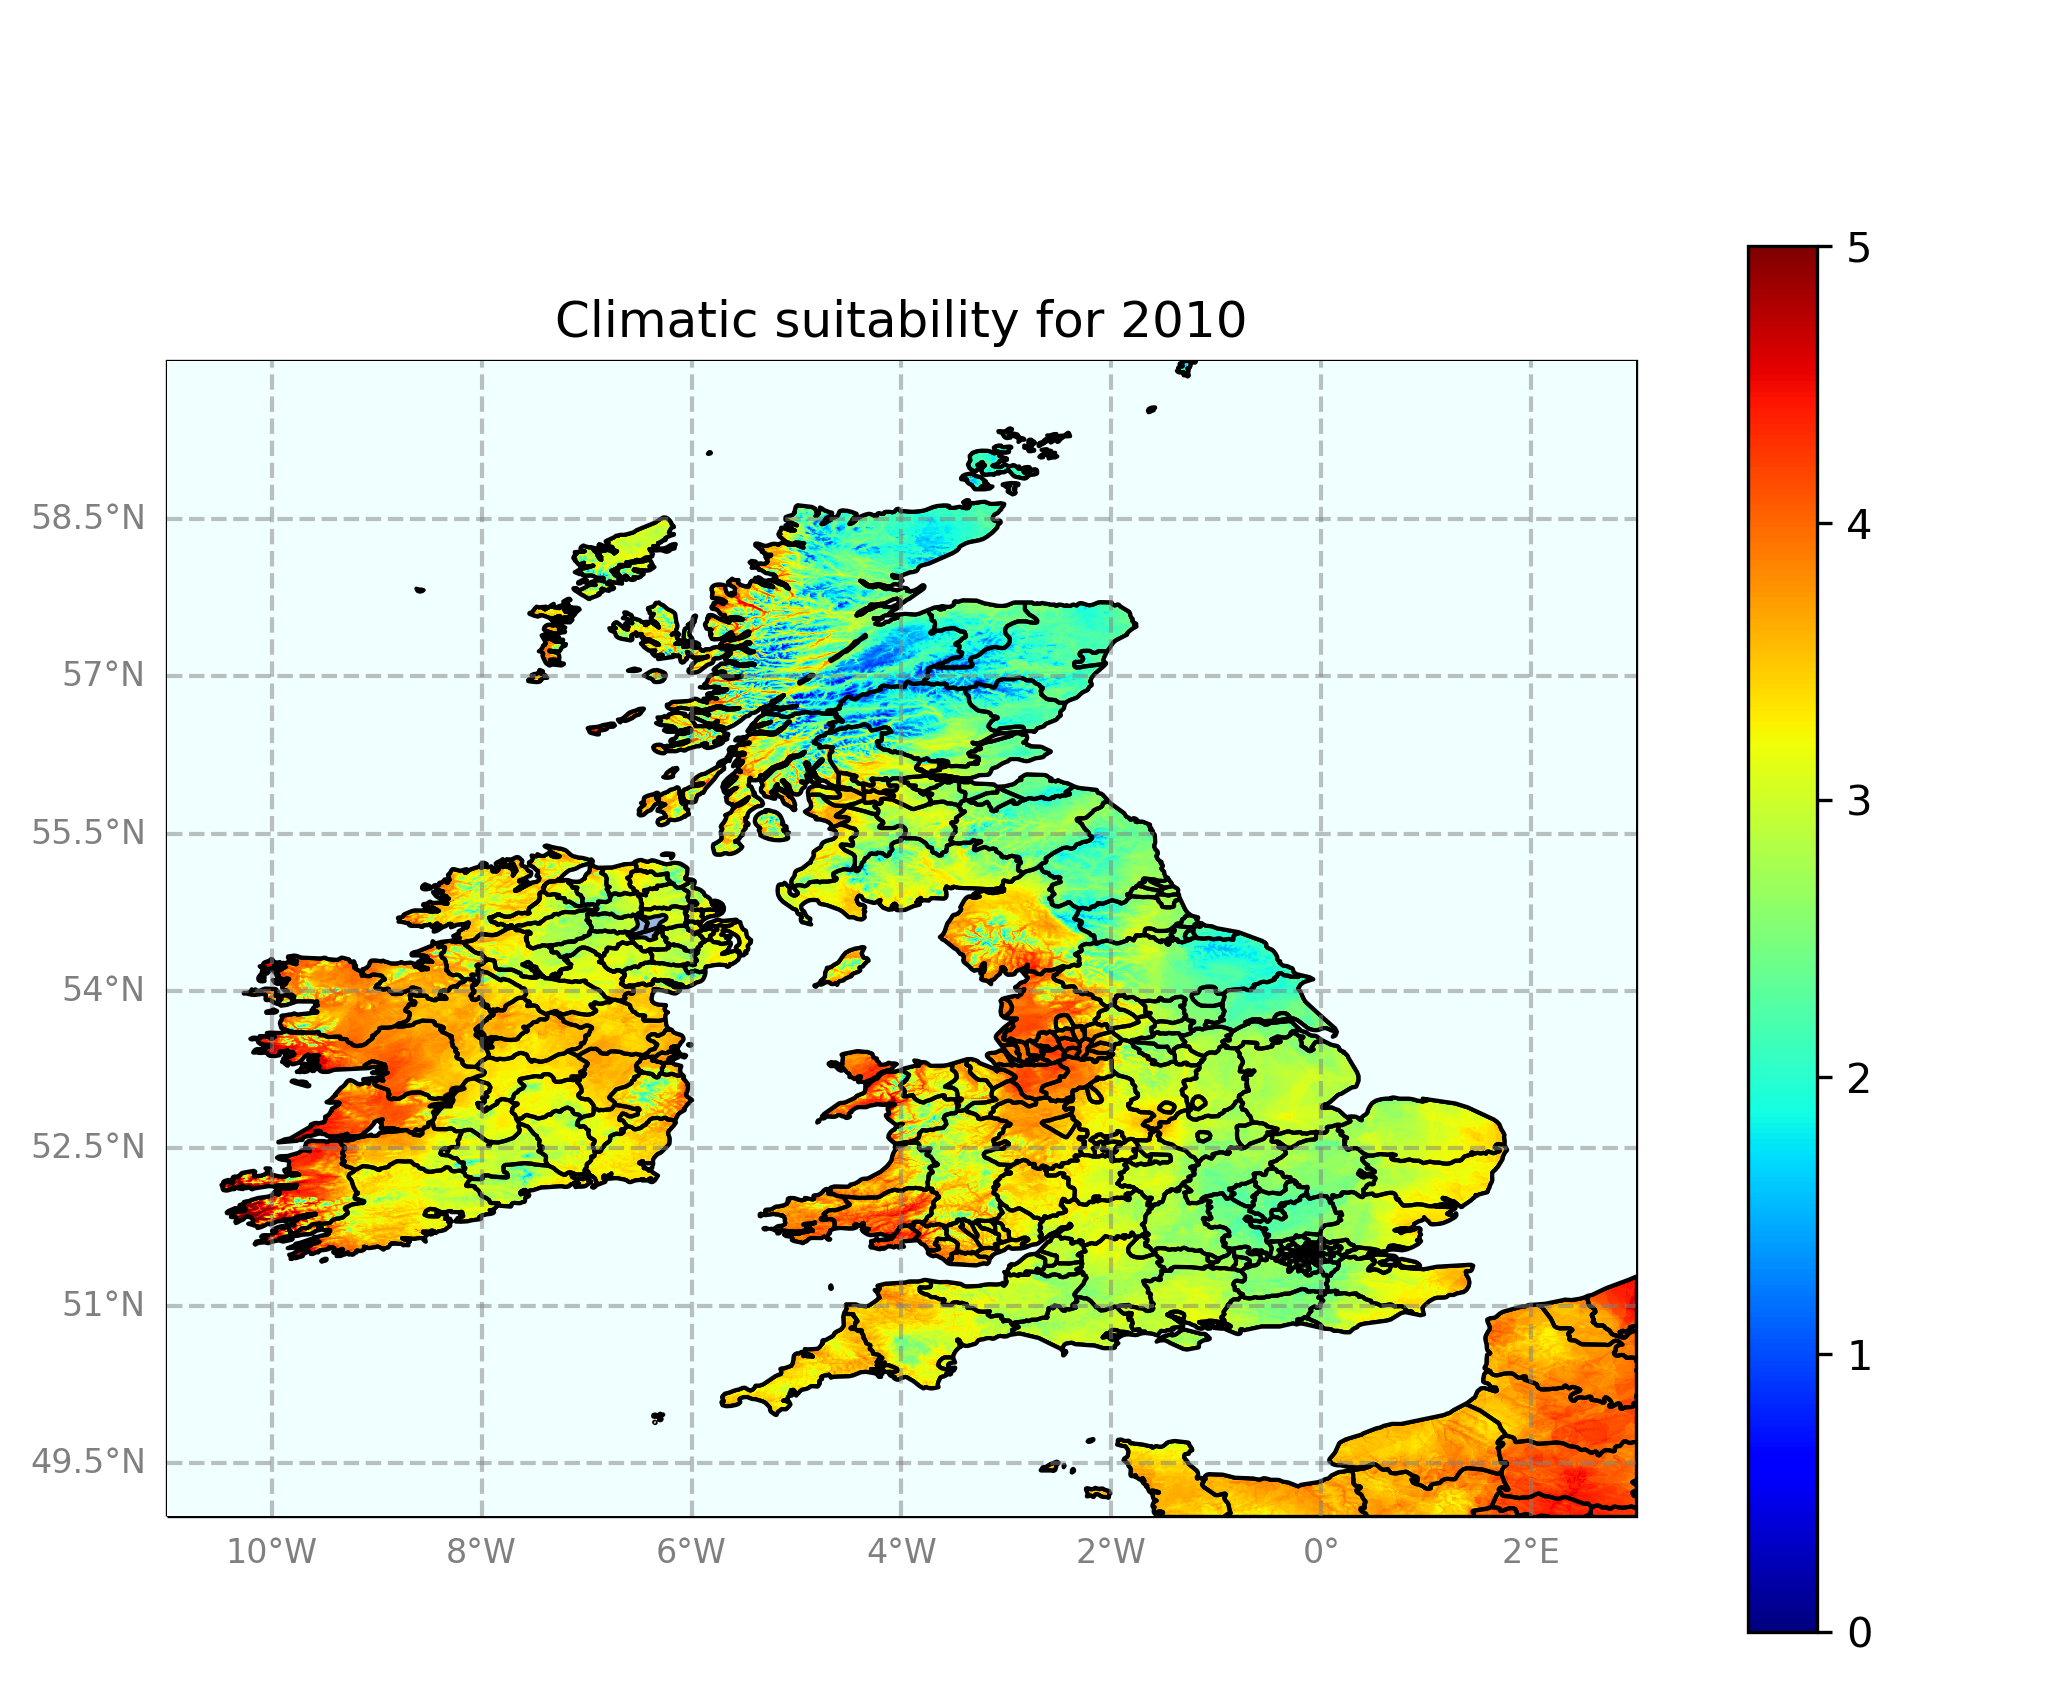

In [4]:
upper_limit = 5

clevels = np.linspace(0, upper_limit, 100)
cbar_ticks = np.arange(0, upper_limit + 1, 1)

location="right"

cbar_label = ""

#clevels = np.linspace(-1, 1, 100)
#cbar_ticks = np.arange(-1, 1.2, 0.2)

filename = "example.png"

title = "Climatic suitability for %i" % year

figsize = (8,6)

save = True

dpi = 300

cmap= plt.cm.jet 

#-- create figure and axes instances
fig = plt.figure(figsize=figsize, dpi=dpi)
ax  = fig.add_axes([0.1,0.1,0.8,0.9])

ax.axis("off")

projection = ccrs.PlateCarree()

#-- create map
ax = plt.axes(projection=projection) 

#-- add map features
ax.coastlines(resolution='10m') #110m, 50m, 10m
ax.add_feature(cartopy.feature.LAND, edgecolor='black')
ax.add_feature(cartopy.feature.LAKES, edgecolor='black')
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black')
ax.add_feature(cartopy.feature.OCEAN, zorder=100, edgecolor='black', facecolor='azure')
ax.add_feature(cartopy.feature.STATES, edgecolor='black')  # provincias y CCAA

cnplot = ax.pcolormesh(lons, lats, suitability_idx, vmin=np.amin(clevels), vmax=np.amax(clevels), cmap=cmap)

cbar = plt.colorbar(cnplot, pad = 0.06, ticks=cbar_ticks, label=cbar_label)

gl = ax.gridlines(crs=projection, linewidth=1, color='gray', alpha=0.5, zorder=200, linestyle='--')

gl.xlabel_style = {'size': 8, 'color': 'gray'}
gl.ylabel_style = {'size': 8, 'color': 'gray'}
gl.bottom_labels = True
gl.left_labels = True

#ax.set_extent(extent)

plt.title(title)

if save == True:

    plt.savefig(filename, dpi=300, bbox_inches="tight")

    #plt.close()